<a href="https://colab.research.google.com/github/joblazek/psp-auction/blob/main/PSP_ladder_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BUYER_COMPUTE i=6: no accepted update (feasible=False, Δu=2999.832346)
BUYER_COMPUTE i=0: no accepted update (feasible=False, Δu=-48.130363)
BUYER_COMPUTE i=4: accepted plan (gen=1), posts scheduled: 2
POST_BID applied: i=4, j=2, (q,p)=(19.8758,14.4868)
BUYER_COMPUTE i=7: no accepted update (feasible=True, Δu=-3.588054)
BUYER_COMPUTE i=3: accepted plan (gen=1), posts scheduled: 1
BUYER_COMPUTE i=5: no accepted update (feasible=True, Δu=0.000000)
BUYER_COMPUTE i=1: accepted plan (gen=1), posts scheduled: 2
BUYER_COMPUTE i=2: accepted plan (gen=1), posts scheduled: 1
POST_BID applied: i=1, j=1, (q,p)=(5.0332,27.9004)
POST_BID applied: i=4, j=1, (q,p)=(14.1407,14.4868)
POST_BID applied: i=3, j=1, (q,p)=(11.7108,19.9206)
POST_BID applied: i=1, j=0, (q,p)=(24.8814,27.9004)
POST_BID applied: i=2, j=1, (q,p)=(10.0665,15.4358)
BUYER_COMPUTE i=6: no accepted update (feasible=False, Δu=2713.717980)
BUYER_COMPUTE i=4: no accepted update (feasible=True, Δu=-29.214861)
BUYER_COMPUTE i=3: no accepte

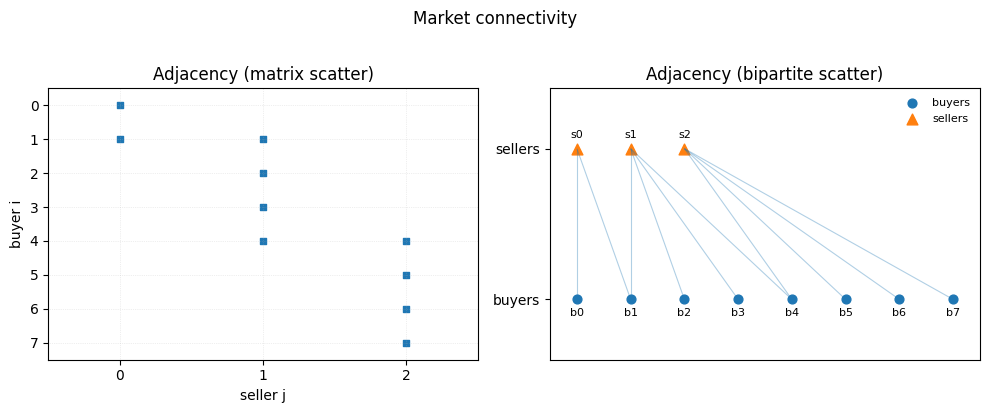

Utility range (buyer 0, seller 0): 0.000000 .. 2627.890564


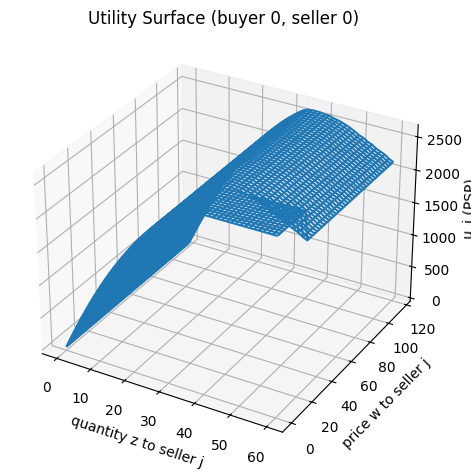

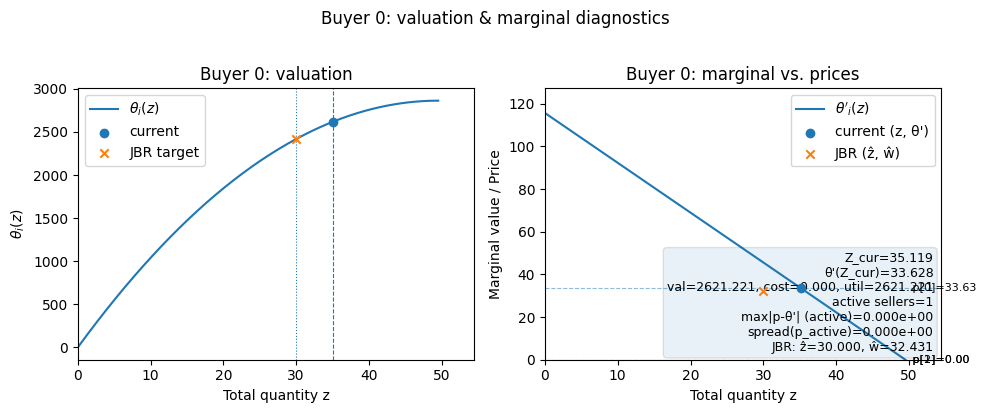

In [ ]:
from __future__ import annotations

import heapq
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# ------------------------------
# Event types
# ------------------------------
BUYER_COMPUTE = 1
POST_BID = 2

# ------------------------------
# Market construction
# ------------------------------

def make_market_multi(I: int,
                      J: int,
                      Q_max: float | np.ndarray = 100.0,
                      epsilon: float = 5.0,
                      reserve: float | np.ndarray = 0.0,
                      budget_range=(5.0, 20.0),
                      q_range=(10.0, 60.0),
                      kappa_range=(1.0, 3.5),
                      seed: int = 12345,
                      jitter: float = 0.01,
                      adj: Optional[np.ndarray] = None) -> Dict:
    """Create a multi-seller PSP market state as flat arrays.

    Buyer arrays (len I): b, qbar, kappa, gen
    Seller arrays (len J): Q_max, reserve
    Bid arrays (I×J): bid_q, bid_p
    """
    rng = np.random.default_rng(seed)
    b = rng.uniform(*budget_range, size=I)
    qbar = rng.uniform(*q_range, size=I)
    kappa = rng.uniform(*kappa_range, size=I)

    Q_max = np.full(J, float(Q_max)) if np.isscalar(Q_max) else np.asarray(Q_max, dtype=float)
    assert Q_max.shape == (J,)
    reserve = np.full(J, float(reserve)) if np.isscalar(reserve) else np.asarray(reserve, dtype=float)
    assert reserve.shape == (J,)

    bid_q = np.zeros((I, J), dtype=float)
    bid_p = np.zeros((I, J), dtype=float)

    M = {
        "I": I,
        "J": J,
        "b": np.ascontiguousarray(b, dtype=float),
        "qbar": np.ascontiguousarray(qbar, dtype=float),
        "kappa": np.ascontiguousarray(kappa, dtype=float),
        "Q_max": np.ascontiguousarray(Q_max, dtype=float),
        "reserve": np.ascontiguousarray(reserve, dtype=float),
        "bid_q": np.ascontiguousarray(bid_q, dtype=float),
        "bid_p": np.ascontiguousarray(bid_p, dtype=float),
        "adj": np.ascontiguousarray(adj, dtype=bool),
        "epsilon": float(epsilon),
        # async engine
        "pq": [],
        "seq": 0,
        "t": 0.0,
        "jitter": float(jitter),
        "rng": rng,
        # buyer generations (staleness guard for POST_BID)
        "gen": np.zeros(I, dtype=np.int64),
        # tolerances
        "tol": 1e-12,
        # convergence bookkeeping
        "pending_posts": 0,
        "events_since_apply": 0,
    }
    return M

# ------------------------------
# Buyer valuation and derivatives
# ------------------------------

def theta_i(i: int, z: float, M: Dict) -> float:
    """θ_i(z) = κ_i * qbar_i * m − 0.5 * κ_i * m^2, with m = min(z, qbar_i)."""
    m = min(z, float(M["qbar"][i]))
    k = float(M["kappa"][i])
    return k * float(M["qbar"][i]) * m - 0.5 * k * m * m


def theta_i_prime(i: int, z: float, M: Dict) -> float:
    """θ'_i(z) = κ_i * (qbar_i − z) for z ≤ qbar_i; 0 beyond."""
    q = float(M["qbar"][i])
    k = float(M["kappa"][i])
    return k * (q - z) if z < q else 0.0

# ------------------------------
# Seller-side primitives (columnwise)
# ------------------------------

def _others_mask(i: int, I: int) -> np.ndarray:
    m = np.ones(I, dtype=bool); m[i] = False; return m


def Q_i_j(i: int, j: int, p: float, M: Dict) -> float:
    """Q_i^j(p): remaining capacity at seller j after removing opponents with price > p."""
    mask = _others_mask(i, M["I"]) ; qcol = M["bid_q"][mask, j] ; pcol = M["bid_p"][mask, j]
    rem = M["Q_max"][j] - float(np.sum(qcol[pcol > p]))
    return rem if rem > 0.0 else 0.0


def Qbar_i_j(i: int, j: int, p: float, M: Dict) -> float:
    """Q̄_i^j(p): remaining capacity at seller j after removing opponents with price ≥ p."""
    mask = _others_mask(i, M["I"]) ; qcol = M["bid_q"][mask, j] ; pcol = M["bid_p"][mask, j]
    rem = M["Q_max"][j] - float(np.sum(qcol[pcol >= p]))
    return rem if rem > 0.0 else 0.0


def P_i_j(i: int, j: int, z: float, M: Dict) -> float:
    """Price density P_i^j(z) = inf{ y ≥ 0 : Q_i^j(y) ≥ z }. Evaluate across candidate prices."""
    others = _others_mask(i, M["I"]) ; cand = np.unique(np.concatenate(([0.0], M["bid_p"][others, j])))
    for y in cand:
        if Q_i_j(i, j, float(y), M) >= z:
            return float(y)
    return float("inf")


def integral_P_i_j(i: int, j: int, a: float, M: Dict, N: int = 100) -> float:
    if a <= 0.0: return 0.0
    zs = np.linspace(0.0, a, N + 1)
    Ps = np.array([P_i_j(i, j, float(zk), M) for zk in zs])
    dz = a / N
    return float(np.trapezoid(Ps, dx=dz))

# ------------------------------
# Current allocation/cost/utility for buyer i (snapshot based)
# ------------------------------

def a_row(i: int, M: Dict) -> Tuple[np.ndarray, float]:
    """Return per-seller allocations a_ij for current bids, and their total."""
    J = M["J"]
    a = np.zeros(J, dtype=float)
    for j in range(J):
        q, p = float(M["bid_q"][i, j]), float(M["bid_p"][i, j])
        a[j] = min(q, Qbar_i_j(i, j, p, M))
    return a, float(np.sum(a))


def cost_row(i: int, a: np.ndarray, M: Dict) -> float:
    J = M["J"]; return float(sum(integral_P_i_j(i, j, float(a[j]), M) for j in range(J)))


def u_i_current(i: int, M: Dict) -> float:
    a, atot = a_row(i, M)
    cost = cost_row(i, a, M)
    return theta_i(i, atot, M) - cost

# ------------------------------
# Joint best response
# ------------------------------


def build_ladders(i: int, M: Dict) -> Dict:
    """
    Build per-seller price ladders of opponents for buyer i:
      - per_seller[j]: dict with fields
          'p'    : opponents' posted prices at seller j (ascending, filtered by adjacency)
          'q'    : aligned opponents' quantities
          'pref' : prefix sums of q (pref[t] = sum_{<t} q_sorted)
          'suf'  : suffix sums of q (suf[t]  = sum_{>=t} q_sorted)
      - steps: sorted global union of {0} ∪ {opponent prices across all sellers} ∪ {w_max}
      - w_max: θ'_i(0)
    """
    I, J = int(M["I"]), int(M["J"])
    others = np.ones(I, dtype=bool); others[i] = False
    has_adj = M.get("adj") is not None

    per_seller = []
    all_steps = [0.0]
    for j in range(J):
        if has_adj:
            opp_ok = M["adj"][others, j]
        else:
            opp_ok = np.ones(I - 1, dtype=bool)
        pcol = np.asarray(M["bid_p"][others, j][opp_ok], dtype=float)
        qcol = np.asarray(M["bid_q"][others, j][opp_ok], dtype=float)
        if pcol.size:
            idx = np.argsort(pcol, kind="mergesort")
            p_sorted = pcol[idx]
            q_sorted = qcol[idx]
            n = p_sorted.size
            pref = np.empty(n + 1, dtype=float); pref[0] = 0.0
            for t in range(n): pref[t + 1] = pref[t] + float(q_sorted[t])
            suf  = np.empty(n + 1, dtype=float); suf[n] = 0.0
            for t in range(n - 1, -1, -1): suf[t] = suf[t + 1] + float(q_sorted[t])
            per_seller.append({"p": p_sorted, "q": q_sorted, "pref": pref, "suf": suf})
            all_steps.extend(np.unique(p_sorted).tolist())
        else:
            per_seller.append({"p": np.array([], float),
                               "q": np.array([], float),
                               "pref": np.array([0.0], float),
                               "suf":  np.array([0.0], float)})
    w_max = float(theta_i_prime(i, 0.0, M))
    steps = np.unique(np.concatenate([np.asarray(all_steps, float), np.array([w_max], float)]))
    return {"per_seller": per_seller, "steps": steps, "w_max": w_max}

def _rem_gt_at(i: int, j: int, y: float, M: Dict, ladders: Dict) -> float:
    """
    Remaining capacity at seller j after removing opponents with price > y (strict '>').
    O(log I) using the ladder. Respects adjacency (i,j).
    """
    if M.get("adj") is not None and not bool(M["adj"][i, j]):
        return 0.0
    L = ladders["per_seller"][j]; p_sorted, suf = L["p"], L["suf"]
    if p_sorted.size == 0:
        return float(M["Q_max"][j])
    idx = int(np.searchsorted(p_sorted, float(y), side="right"))
    taken = float(suf[idx])
    rem = float(M["Q_max"][j]) - taken
    return rem if rem > 0.0 else 0.0

def _equals_mass_at(j: int, y: float, ladders: Dict) -> float:
    """
    Total opponents' quantity at seller j with price exactly y.
    """
    L = ladders["per_seller"][j]; p_sorted, pref = L["p"], L["pref"]
    if p_sorted.size == 0:
        return 0.0
    left  = int(np.searchsorted(p_sorted, float(y), side="left"))
    right = int(np.searchsorted(p_sorted, float(y), side="right"))
    return float(pref[right] - pref[left])

def _equals_count_at(j: int, y: float, ladders: Dict) -> int:
    """
    Number of opponents at seller j with price exactly y (for count-based QJC).
    """
    L = ladders["per_seller"][j]; p_sorted = L["p"]
    if p_sorted.size == 0:
        return 0
    left  = int(np.searchsorted(p_sorted, float(y), side="left"))
    right = int(np.searchsorted(p_sorted, float(y), side="right"))
    return int(max(0, right - left))

def seller_caps_at(i: int, y: float, M: Dict, ladders: Dict) -> np.ndarray:
    """
    Caps z_caps[j] available to buyer i at price boundary yy under a tie policy,
        split residual among equals by COUNT (approx QJC)
    """
    J = int(M["J"]); caps = np.zeros(J, dtype=float)
    for j in range(J):
        rem = _rem_gt_at(i, j, y, M, ladders)
        # Split residual among equal-price group (opponents at y plus buyer i)
        eq_cnt = 1 + _equals_count_at(j, y, ladders)
        caps[j] = (rem / float(eq_cnt)) if rem > 0.0 else 0.0
        # We cannot determine a quantity-proportional cap without q_ij.
        # Return the open cap; we'll enforce QJC proportionally after we pick q_row.
        #caps[j] = rem
    return caps

def sup_G_i_multi(i: int, M: Dict, ladders: Dict
                  ) -> Tuple[float, np.ndarray, float, Dict]:
    """
    Stepwise selection of w*: scan open intervals (y_k, y_{k+1}) for interior fixed point.
    If none, choose a boundary according to Jia Caine
    Returns: w_star, caps, z_star, meta  (meta = {'type': 'interior'|'boundary', 'y': y_star})
    """
    tol = float(M["tol"])
    steps = ladders["steps"]; w_max = float(ladders["w_max"])

    # 1) Try to find interior solution
    for k in range(steps.size - 1):
        yk, yk1 = float(steps[k]), float(steps[k + 1])
        if yk1 <= yk + tol:
            continue
        # availability is constant on (yk, yk1): evaluate at left boundary with strict '>'
        z_caps = seller_caps_at(i, yk, M, ladders)
        Z = float(np.sum(z_caps))
        w_imp = float(theta_i_prime(i, Z, M))
        if (w_imp > yk + tol) and (w_imp < yk1 - tol):
            z_star = min(float(M["qbar"][i]), Z)
            return w_imp, z_caps, z_star, {"type": "interior", "y": None}

    # 2) No interior: compute f(y_k) = θ'(Z_k) - y_k at each left boundary and locate crossing
    f_vals = []
    for k in range(steps.size - 1):  # exclude last boundary as a left boundary
        yk = float(steps[k])
        z_caps = seller_caps_at(i, yk, M, ladders)
        Zk = float(np.sum(z_caps))
        f_vals.append(float(theta_i_prime(i, Zk, M) - yk))

    # If degenerate (no opponents), take y*=0 as "lower"
    if len(f_vals) == 0:
        k_star = 0
    else:
        k_star = max([idx for idx, fv in enumerate(f_vals) if fv >= -tol], default=0)

    y_lower = float(steps[k_star])
    y_upper = float(steps[min(k_star + 1, steps.size - 1)])  # right boundary of that interval

    # Helper to build a *complete* plan at a boundary and return (w, caps, z_star, q_row, p_row, cost, u, feasible, meta)
    def eval_boundary(which: str):
        if which == "lower":
            w = y_lower
            caps = seller_caps_at(i, y_lower, M, ladders)
            meta = {"type": "boundary", "y": y_lower}
        elif which == "upper":
            # choose w just below the upper boundary; caps from open interval at y_lower
            w = max(y_upper - tol, 0.0)
            caps = seller_caps_at(i, y_lower, M, ladders)
            meta = {"type": "boundary", "y": y_upper}
        else:
            raise ValueError(which)

        z_star = min(float(M["qbar"][i]), float(np.sum(caps)))
        q_row, p_row, cost, u_new, feasible = compute_t_i_multi(
            i, M, w, caps, z_star, meta
        )
        return w, caps, z_star, q_row, p_row, cost, u_new, feasible, meta
    endpoint_policy = "upper"
    ep = str(endpoint_policy).lower()
    # legacy endpoint behaviors
    if ep == "upper":
        w_star = max(y_upper - tol, 0.0)
        caps   = seller_caps_at(i, y_lower, M, ladders)
        z_star = min(float(M["qbar"][i]), float(np.sum(caps)))
        return w_star, caps, z_star, {"type": "boundary", "y": y_upper}
    elif ep in ("lower", "qjc"):
        w_star = y_lower
        caps   = seller_caps_at(i, y_lower, M, ladders)
        z_star = min(float(M["qbar"][i]), float(np.sum(caps)))
        return w_star, caps, z_star, {"type": "boundary", "y": y_lower}
    else:
        # default to lower
        w_star = y_lower
        caps   = seller_caps_at(i, y_lower, M, ladders)
        z_star = min(float(M["qbar"][i]), float(np.sum(caps)))
        return w_star, caps, z_star, {"type": "boundary", "y": y_lower}

def _subset_uniform_split(z_star: float, caps: np.ndarray) -> np.ndarray:
    """
    Choose the smallest subset whose caps sum ≥ z_star (descending caps),
    then equal-split water-fill under per-seller caps.
    """
    J = caps.size
    order = np.argsort(-caps, kind="mergesort")
    cum = 0.0; S: List[int] = []
    for j in order:
        if caps[j] <= 0.0: continue
        S.append(int(j)); cum += float(caps[j])
        if cum >= z_star - 1e-15: break
    q_row = np.zeros(J, dtype=float)
    if z_star <= 0.0 or not S:
        return q_row
    tol_cap = 1e-12
    cap_map = {j: float(caps[j]) for j in S}
    while True:
        active = [j for j in S if q_row[j] < cap_map[j] - tol_cap]
        rem = z_star - float(np.sum(q_row))
        if rem <= tol_cap or not active:
            break
        share = rem / len(active)
        progress = 0.0
        for j in active:
            add = min(share, cap_map[j] - q_row[j])
            if add > 0.0:
                q_row[j] += add; progress += add
        if progress <= tol_cap:
            break
    return q_row

def _per_seller_segments_upto(i: int, j: int, y_ref: float, M: Dict, ladders: Dict) -> List[Tuple[float, float, int]]:
    """
    Return price segments for seller j up to boundary y_ref as a list of
      (price_level, segment_length, j).
    Segment at price y_t represents the additional capacity unlocked exactly at y_t.
    Includes the y=0 segment if any capacity is available at 0.
    Respects adjacency (i,j).
    """
    if M.get("adj") is not None and not bool(M["adj"][i, j]):
        return []

    L = ladders["per_seller"][j]
    p_sorted = L["p"]

    # All local step prices up to y_ref (inclusive), plus 0
    if p_sorted.size:
        steps_j = np.unique(np.concatenate(([0.0], p_sorted[p_sorted <= float(y_ref)])))
    else:
        steps_j = np.array([0.0], dtype=float)

    segs: List[Tuple[float, float, int]] = []
    prev_rem = 0.0
    for y in steps_j:
        rem = _rem_gt_at(i, j, float(y), M, ladders)   # remaining capacity with strict '>'
        delta = rem - prev_rem
        if delta > 1e-15:
            # Units first available at price y get priced at y
            segs.append((float(y), float(delta), int(j)))
        prev_rem = rem
    return segs

def apply_budget_policy(i: int, M: Dict, q_row: np.ndarray, base_cost: float
                         ) -> Tuple[np.ndarray, float, float, bool]:
    """
    Returns (q_row_new, cost_new, u_new, feasible).
        if cost>b_i, reject
    """
    b_i = float(M["b"][i])
    Z0 = float(np.sum(q_row))

    def util_from(qv: np.ndarray, c: float) -> float:
        return theta_i(i, float(np.sum(qv)), M) - float(c)

    # Accept if already within budget (small tolerance)
    if base_cost <= b_i + 1e-9:
        return q_row, base_cost, util_from(q_row, base_cost), True

    return q_row, base_cost, util_from(q_row, base_cost), False

def compute_t_i_multi(i: int, M: Dict,
                      w_star: float, caps: np.ndarray, z_star: float, meta: Dict
                      ) -> Tuple[np.ndarray, np.ndarray, float, float, bool]:
    """
    Build (q_row, p_row) from (w_star, caps, z_star):
    """
    # 1) split to z_star under caps
    q_row = _subset_uniform_split(z_star, caps)

    # 2) prices
    p_row = np.full(int(M["J"]), float(w_star), dtype=float)

    # 3) cost & budget
    base_cost = cost_row(i, q_row, M)
    q_row, cost_new, u_new, feasible = apply_budget_policy(
        i, M, q_row, base_cost)
    return q_row, p_row, cost_new, u_new, feasible

def joint_best_response_plan(i: int, M: Dict) -> Tuple[np.ndarray, np.ndarray, bool, float]:
    # read policies (with defaults)

    ladders = build_ladders(i, M)
    w_star, caps, z_star, meta = sup_G_i_multi(
        i, M, ladders)

    q_row, p_row, cost, u_new, feasible = compute_t_i_multi(
        i, M, w_star, caps, z_star, meta)
    return q_row, p_row, feasible, u_new

# ------------------------------
# Priority queue helpers
# ------------------------------

def push(M: Dict, t: float, etype: int, payload: Tuple):
    M["seq"] += 1
    heapq.heappush(M["pq"], (float(t), int(M["seq"]), int(etype), payload))

def pop(M: Dict):
    return heapq.heappop(M["pq"]) if M["pq"] else None

def schedule_all_buyers(M: Dict, t0: float = 0.0):
    rng = M["rng"]
    for i in range(M["I"]):
        push(M, t0 + float(rng.random() * M["jitter"]), BUYER_COMPUTE, (i,))

# ------------------------------
# Event handlers
# ------------------------------

def handle_buyer_compute(M: Dict, i: int, verbose: bool = False, debug: bool = False):
    base_t = M["t"]
    old_u = u_i_current(i, M)

    q_row, p_row, feasible, u_new = joint_best_response_plan(i, M)

    # Always reschedule compute for Gauss–Seidel cadence
    push(M, base_t + 1.0 + float(M["rng"].random() * M["jitter"]), BUYER_COMPUTE, (i,))

    if (not feasible) or (u_new <= old_u + float(M["epsilon"])):
        if verbose:
            print(f"BUYER_COMPUTE i={i}: no accepted update (feasible={feasible}, Δu={u_new-old_u:.6f})")
        return False

    # Accept plan: increment generation and schedule one POST_BID per changed cell
    M["gen"][i] += 1
    gen_now = int(M["gen"][i])

    J = M["J"]; tol = 1e-12
    changed = False
    num_posts = 0
    for j in range(J):
        if not M["adj"][i, j]:
            continue
        dq = abs(float(M["bid_q"][i, j]) - float(q_row[j]))
        dp = abs(float(M["bid_p"][i, j]) - float(p_row[j]))
        old_q = float(M["bid_q"][i, j]); new_q = float(q_row[j])
        if dq > tol or ((old_q > 0.0) or (new_q > 0.0)):
            changed = True
            num_posts += 1
            t_post = base_t + float(M["rng"].random() * M["jitter"])  # activate later
            push(M, t_post, POST_BID, (i, j, float(q_row[j]), float(p_row[j]), gen_now))
    if num_posts:
        M["pending_posts"] += num_posts
    if verbose:
        if changed:
            print(f"BUYER_COMPUTE i={i}: accepted plan (gen={gen_now}), posts scheduled: {num_posts}")
        else:
            print(f"BUYER_COMPUTE i={i}: plan equals current bids, nothing to post")
    return changed

def handle_post_bid(M: Dict, i: int, j: int, q: float, p: float, gen: int, verbose: bool = False, debug: bool = False):
    # Block if (i,j) is not connected
    if not M["adj"][i, j]:
        if M.get("pending_posts", 0) > 0:
            M["pending_posts"] -= 1
        if debug:
            print(f"POST_BID blocked (no edge): i={i}, j={j}")
        return False

    # Generation guard
    if (int(M["gen"][i]) != int(gen)):
        if verbose:
            print(f"POST_BID stale drop: i={i}, j={j}, gen={gen} (current gen={int(M['gen'][i])})")
        return False
    # fresh -> apply
    M["bid_q"][i,j] = float(q); M["bid_p"][i,j] = float(p)

    if M.get("pending_posts", 0) > 0:
        M["pending_posts"] -= 1
    M["events_since_apply"] = 0
    if verbose:
        print(f"POST_BID applied: i={i}, j={j}, (q,p)=({q:.4f},{p:.4f})")
    return True

# ------------------------------
# Engine run loop
# ------------------------------

def run(M: Dict, steps: int = 1000, verbose: bool = False, *, idle_event_limit: int | None = None):
    """Run the async engine.

    break_on_convergence: stop when no POST_BID has applied for
      idle_event_limit events and there are no pending POST_BIDs.
    idle_event_limit: default = 4*I (set at runtime if None).
    """
    if idle_event_limit is None:
        idle_event_limit = int(M["I"]) if M["I"] else 4

    for _ in range(steps):
        item = pop(M)
        if item is None:
            break
        t, _, etype, payload = item
        M["t"] = float(t)
        if etype == BUYER_COMPUTE:
            (i,) = payload
            handle_buyer_compute(M, int(i), verbose=verbose)
            # no apply occurred here; count toward idle if nothing applied elsewhere
            M["events_since_apply"] += 1
        elif etype == POST_BID:
            i, j, q, p, gen = payload
            handle_post_bid(M, int(i), int(j), float(q), float(p), int(gen), verbose=verbose)
            # events_since_apply reset inside handler on apply
        else:
            raise RuntimeError(f"Unknown event type {etype}")

        # Convergence check: no pending posts and long idle since last apply
        if M.get("pending_posts", 0) == 0 and M.get("events_since_apply", 0) >= idle_event_limit:
            print(f"Converged: no price updates for {M['events_since_apply']} events; pending_posts=0")
            break

# ------------------------------
# Demo (__main__)
# ------------------------------
if __name__ == "__main__":
    I, J = 8, 3
    plot = True
    adj = bipartite_membership(I, J)
    M = make_market_multi(I, J, Q_max=np.array([60, 40, 50]), epsilon=2.5, reserve=np.zeros(J), seed=20250823, adj=adj)
    randomize_bids(M)

    # Schedule and run
    schedule_all_buyers(M, t0=0.0)
    run(M, steps=1000, verbose=True)

    df = market_snapshot(M).round(3)
    print(df)
    per_seller_df = per_seller_totals(M)
    print("\nPer-seller totals:")
    print(per_seller_df)
    tot = market_totals(M)
    print(f"Market Totals -> TotalAlloc: {tot[0]:.2f}, TotalValue: {tot[1]:.2f}, TotalUtility: {tot[2]:.2f}")

    if plot:
        plot_connectivity(M, title="Market connectivity", show_labels=True)
        plot_utility_surface(M, 0, 0)
        plot_buyer_diagnostics(M, i=0, show_jbr=True)


In [ ]:

# ------------------------------
# Reporting helpers
# ------------------------------

def market_snapshot(M: Dict) -> pd.DataFrame:
    I, J = M["I"], M["J"]
    rows = []
    for i in range(I):
        a, atot = a_row(i, M)
        cost = cost_row(i, a, M)
        row = {
            "i": i,
            "a_total": atot,
            "qbar": float(M["qbar"][i]),
            "kappa": float(M["kappa"][i]),
            "u_i": theta_i(i, atot, M) - cost,
            "cost": cost,
        }
        # include a few columns for readability
        for j in range(J):
            row[f"q[{j}]"] = float(M["bid_q"][i, j])
            row[f"p[{j}]"] = float(M["bid_p"][i, j])
        rows.append(row)
    df = pd.DataFrame(rows)
    return df

def market_totals(M: Dict) -> Tuple[float, float, float]:
    I = M["I"]
    total_alloc = 0.0; total_value = 0.0; total_util = 0.0
    for i in range(I):
        a, atot = a_row(i, M)
        cost = cost_row(i, a, M)
        total_alloc += atot
        total_value += theta_i(i, atot, M)
        total_util += theta_i(i, atot, M) - cost
    return total_alloc, total_value, total_util

def market_totals_by_seller(M: Dict) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Note: Valuation/utility attribution is for reporting (it partitions totals across sellers);
    PSP revenue (actual payments) is not returned here—use market_revenue_by_seller().
    """
    J = int(M["J"])
    alloc_j = np.zeros(J, dtype=float)
    value_j = np.zeros(J, dtype=float)
    util_j  = np.zeros(J, dtype=float)

    for i in range(int(M["I"])):
        a_vec, atot = a_row(i, M)  # a_ij = min(q_ij, Q̄_i^j(p_ij))
        # accumulate allocations
        alloc_j += a_vec.astype(float)

        # per-seller PSP costs (revenue) for buyer i
        cost_j = np.array([integral_P_i_j(i, j, float(a_vec[j]), M) for j in range(J)], dtype=float)
        cost_i = float(cost_j.sum())

        v_i = theta_i(i, float(atot), M)
        u_i = v_i - cost_i

        if atot > 0.0:
            weights = (a_vec / float(atot))
            value_j += weights * v_i
            util_j  += weights * u_i
        # else: buyer contributes nothing

    return alloc_j, value_j, util_j

def market_revenue_by_seller(M: Dict) -> np.ndarray:
    """
    PSP revenue collected at each seller: rev_j[j] = sum_i ∫_0^{a_ij} P_i^j(z) dz
    """
    J = int(M["J"])
    rev_j = np.zeros(J, dtype=float)
    for i in range(int(M["I"])):
        a_vec, _ = a_row(i, M)
        for j in range(J):
            rev_j[j] += float(integral_P_i_j(i, j, float(a_vec[j]), M))
    return rev_j

def per_seller_totals(M: Dict) -> pd.DataFrame:
    # Per-seller totals
    alloc_j, value_j, util_j = market_totals_by_seller(M)
    rev_j = market_revenue_by_seller(M)

    per_seller_df = pd.DataFrame({
        "seller": np.arange(M["J"]),
        "alloc":  alloc_j,
        "value":  value_j,
        "util":   util_j,
        "revenue": rev_j,
        "Q_max":  M["Q_max"],
    }).round(3)
    return per_seller_df

In [ ]:
# ------------------------------
# Valuation and utility surface plots
# ------------------------------

def plot_buyer_diagnostics(M: Dict, i: int, *, show_jbr: bool = True, num_points: int = 200):
    """
    One-stop diagnostic for buyer i:
      - Left: valuation θ_i(z) with current total allocation Z_cur marked.
      - Right: marginal θ'_i(z) with (Z_cur, θ'_i(Z_cur)), seller price lines p[i,j],
               and (optionally) the JBR target point (Z_hat, w_hat) from a dry-run.
      - Prints deviation metrics: max |p[i,j] - θ'_i(Z_cur)| on active sellers, spread of p’s, etc.
    """
    # ----- current snapshot totals -----
    a_vec, Z_cur = a_row(i, M)                              # allocations under current bids
    val_cur = theta_i(i, float(Z_cur), M)
    w_eff   = theta_i_prime(i, float(Z_cur), M)

    # Per-seller PSP cost (for info box)
    J = int(M["J"])
    cost_cur = sum(float(integral_P_i_j(i, j, float(a_vec[j]), M)) for j in range(J))
    util_cur = val_cur - cost_cur

    # Active sellers for this buyer
    active = (a_vec > 1e-12)
    p_row = M["bid_p"][i, :]
    p_active = p_row[active] if np.any(active) else np.array([], dtype=float)
    max_dev = float(np.max(np.abs(p_active - w_eff))) if p_active.size else 0.0
    spread  = float(np.ptp(p_active)) if p_active.size > 1 else 0.0

    # ----- optional JBR target (dry run; not applied) -----
    Z_hat, w_hat = None, None
    if show_jbr:
        q_hat, p_hat, feasible, u_hat = joint_best_response_plan(i, M)
        if feasible:
            Z_hat = float(np.sum(q_hat))
            w_hat = float(p_hat[0]) if len(p_hat) else 0.0

    # ----- curves -----
    zmax = float(M["qbar"][i])
    Zs = np.linspace(0.0, max(zmax, 1e-12), num_points)
    vals  = np.array([theta_i(i, float(z), M)       for z in Zs], dtype=float)
    mvals = np.array([theta_i_prime(i, float(z), M) for z in Zs], dtype=float)

    # ----- plotting -----
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axV, axM = axes

    # Valuation
    axV.plot(Zs, vals, label=r"$\theta_i(z)$")
    axV.axvline(float(Z_cur), linestyle="--", linewidth=0.8)
    axV.scatter([Z_cur], [val_cur], zorder=5, label="current")
    if show_jbr and (Z_hat is not None):
        axV.axvline(Z_hat, linestyle=":", linewidth=0.8)
        axV.scatter([Z_hat], [theta_i(i, Z_hat, M)], marker="x", zorder=6, label="JBR target")

    axV.set_xlabel("Total quantity z")
    axV.set_ylabel(r"$\theta_i(z)$")
    axV.set_title(f"Buyer {i}: valuation")
    axV.legend(loc="best")
    axV.set_xlim(0.0, zmax * 1.1 if zmax > 0 else 1.0)

    # Marginal
    axM.plot(Zs, mvals, label=r"$\theta'_i(z)$")
    axM.scatter([Z_cur], [w_eff], zorder=5, label="current (z, θ')")
    if show_jbr and (w_hat is not None):
        axM.scatter([Z_hat], [w_hat], marker="x", zorder=6, label="JBR (ẑ, ŵ)")

    # Seller price lines for this buyer
    for j in range(J):
        pj = float(p_row[j])
        axM.axhline(pj, linestyle="--", linewidth=0.8, alpha=0.5)
        # annotate on the right margin
        axM.text(zmax * 1.01 if zmax > 0 else 0.01, pj, f" p[{j}]={pj:.2f}",
                 va="center", fontsize=8)

    axM.set_xlabel("Total quantity z")
    axM.set_ylabel("Marginal value / Price")
    axM.set_title(f"Buyer {i}: marginal vs. prices")
    axM.legend(loc="best")
    ylim_max = max(
        (mvals.max() if mvals.size else 1.0),
        (float(np.max(p_row)) if J > 0 else 0.0)
    ) * 1.1
    if ylim_max <= 0: ylim_max = 1.0
    axM.set_xlim(0.0, zmax * 1.1 if zmax > 0 else 1.0)
    axM.set_ylim(0.0, ylim_max)

    # Info box (right)
    txt = [
        f"Z_cur={Z_cur:.3f}",
        f"θ'(Z_cur)={w_eff:.3f}",
        f"val={val_cur:.3f}, cost={cost_cur:.3f}, util={util_cur:.3f}",
        f"active sellers={int(np.sum(active))}",
        f"max|p-θ'| (active)={max_dev:.3e}",
        f"spread(p_active)={spread:.3e}",
    ]
    if show_jbr and (Z_hat is not None):
        txt += [f"JBR: ẑ={Z_hat:.3f}, ŵ={w_hat:.3f}"]
    axM.text(0.98, 0.02, "\n".join(txt), ha="right", va="bottom",
             transform=axM.transAxes, fontsize=9,
             bbox=dict(boxstyle="round,pad=0.3", alpha=0.1))

    fig.suptitle(f"Buyer {i}: valuation & marginal diagnostics", y=1.02)
    fig.tight_layout()
    plt.show()

def plot_utility_surface(M: Dict, i: int, j: int, q_steps: int = 50, p_steps: int = 50):
    """Plot u_i under PSP cost while varying (q,p) at seller j.
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D # noqa: F401 (needed for 3D projection)

    zs = np.linspace(0.0, float(M["Q_max"][j]), q_steps)
    w_max = theta_i_prime(i, 0.0, M)
    ws = np.linspace(0.0, max(w_max, 1e-12), p_steps)
    Z, W = np.meshgrid(zs, ws)
    U = np.zeros_like(Z)

    # snapshot original cell and compute
    q_old = float(M["bid_q"][i, j]); p_old = float(M["bid_p"][i, j])
    for r in range(p_steps):
      for c in range(q_steps):
        M["bid_q"][i, j] = float(Z[r, c])
        M["bid_p"][i, j] = float(W[r, c])
        U[r, c] = u_i_current(i, M)
    M["bid_q"][i, j] = q_old
    M["bid_p"][i, j] = p_old

    print(f"Utility range (buyer {i}, seller {j}): {U.min():.6f} .. {U.max():.6f}")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(Z, W, U, rstride=1, cstride=1)
    ax.set_xlabel('quantity z to seller j')
    ax.set_ylabel('price w to seller j')
    ax.set_zlabel('u_i (PSP)')
    ax.set_title(f'Utility Surface (buyer {i}, seller {j})')
    plt.tight_layout(); plt.show()

# ------------------------------
# Connectivity plots
# ------------------------------

def plot_connectivity(M: Dict, *, title: Optional[str] = None, show_labels: bool = True):
    """
    Visualize market connectivity M["adj"] (I x J boolean) with:
      - Left: matrix scatter (buyer index vs seller index)
      - Right: bipartite layout (buyers at y=0, sellers at y=1, edges as line segments)
    """
    if "adj" not in M:
        raise ValueError("M['adj'] not found. Pass an (I x J) boolean adjacency matrix in make_market_multi(...).")

    adj = np.asarray(M["adj"], dtype=bool)
    I, J = adj.shape
    ii, jj = np.nonzero(adj)  # edge endpoints (buyer i, seller j)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axL, axR = axes

    # --- Left: matrix scatter view ---
    axL.scatter(jj, ii, s=25, marker='s')
    axL.set_xlabel("seller j")
    axL.set_ylabel("buyer i")
    axL.set_xlim(-0.5, J - 0.5)
    axL.set_ylim(I - 0.5, -0.5)  # buyer 0 at top
    axL.set_xticks(range(J))
    axL.set_yticks(range(I))
    axL.set_title("Adjacency (matrix scatter)")
    axL.grid(True, linestyle=":", linewidth=0.5, alpha=0.4)

    # --- Right: bipartite scatter view ---
    # buyers at y=0, sellers at y=1
    x_b = np.arange(I); y_b = np.zeros(I)
    x_s = np.arange(J); y_s = np.ones(J)

    axR.scatter(x_b, y_b, s=40, label="buyers")
    axR.scatter(x_s, y_s, s=60, marker="^", label="sellers")

    # Build edge segments efficiently
    if ii.size:
        segments = [((x_b[i], 0.0), (x_s[j], 1.0)) for i, j in zip(ii, jj)]
        lc = LineCollection(segments, linewidths=0.8, alpha=0.35)
        axR.add_collection(lc)

    if show_labels:
        for i in range(I):
            axR.text(x_b[i], -0.06, f"b{i}", ha="center", va="top", fontsize=8)
        for j in range(J):
            axR.text(x_s[j], 1.06, f"s{j}", ha="center", va="bottom", fontsize=8)

    axR.set_xlim(-0.5, max(I, J) - 0.5)
    axR.set_ylim(-0.4, 1.4)
    axR.set_yticks([0, 1]); axR.set_yticklabels(["buyers", "sellers"])
    axR.set_xticks([])
    axR.set_title("Adjacency (bipartite scatter)")
    axR.legend(loc="upper right", fontsize=8, frameon=False)

    if title:
        fig.suptitle(title, y=1.02)
    fig.tight_layout()
    plt.show()

# ------------------------------
# Initialization helpers
# ------------------------------

def randomize_bids(M: Dict):
    rng = M["rng"]
    I, J = int(M["I"]), int(M["J"])
    include_prob = 0.4
    for i in range(I):
        z_total = float(rng.uniform(0.0, float(M["qbar"][i])))
        if J == 0 or z_total <= 0.0:
            continue
        # restrict candidate sellers to those connected to i
        cand = np.nonzero(M["adj"][i, :])[0]
        if cand.size == 0:
            continue
        mask = np.zeros(J, dtype=bool)
        # choose subset from cand
        chosen = cand[rng.random(cand.size) < include_prob]
        if chosen.size == 0:
            chosen = np.array([rng.choice(cand)])
        mask[chosen] = True
        idxs = np.nonzero(mask)[0]
        k = len(idxs)
        weights = rng.dirichlet(np.ones(k)) if k > 1 else np.array([1.0])
        shares = z_total * weights
        for t, j in enumerate(idxs):
            M["bid_q"][i, j] = float(shares[t])
        p_uniform = theta_i_prime(i, z_total, M)
        for j in idxs:
            M["bid_p"][i, j] = float(p_uniform)

def clustered_membership(I: int, J: int) -> np.array:
    adj = np.zeros((I, J), dtype=bool)
    adj[0:4, 0:2] = True   # group A
    adj[4:8, 1:3] = True   # group B
    return adj

def random_bipartite(I:int, J: int, density: float) -> np.array:
    return (np.random.default_rng(42).random((I, J)) < density)

def bipartite_membership(I: int, J: int) -> np.array:
    """
    Creates a bipartite adjacency matrix where:
    - All buyers are connected to at least one seller.
    - Some sellers have unique buyer members.
    - Some sellers share buyer members.
    """
    adj = np.zeros((I, J), dtype=bool)

    # Ensure J >= 3 for the desired structure
    if J < 3:
        print("Warning: J should be at least 3 for the desired bipartite structure.")
        # Fallback to a simpler all-to-all connection if J is too small
        adj[:, :] = True
        return adj

    # Connect first few buyers to the first seller (unique)
    split1 = min(I, I // 3)
    adj[:split1, 0] = True

    # Connect a middle group of buyers to the second seller (shared)
    split2 = min(I, split1 + I // 3)
    adj[max(0, split1 - I // 6):split2 + I // 6, 1] = True

    # Connect the remaining buyers to the third seller (unique for the upper end)
    adj[max(0, split2):, 2] = True

    # Ensure all buyers are connected
    for i in range(I):
        if not np.any(adj[i, :]):
            # If a buyer is not connected, connect them to seller 0 as a default
            adj[i, 0] = True

    return adj